In [6]:
import faiss
import numpy as np
import pandas as pd
from transformers import CLIPModel, CLIPProcessor
from sklearn.metrics.pairwise import cosine_similarity

from api import utils

def load_model() -> tuple[CLIPModel, CLIPProcessor]:
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    return model, processor

In [2]:
model, processor = load_model()

In [86]:
df = pd.read_csv("embeddings/embeddings.csv")

In [88]:
urls = df["url"].tolist()

In [89]:
emb = np.load("embeddings/embeddings.npy")
emb /= np.linalg.norm(emb, axis=1, keepdims=True)

In [90]:
_, d = emb.shape

In [91]:
index = faiss.IndexFlatL2(d)
index.add(emb)

In [92]:
def search(query: str, index: faiss.Index) -> list[str]:
    q = utils.compute_embedding(model, processor, [query], "text")
    q /= np.linalg.norm(q)
    _, I = index.search(q, k=5)
    I = I.flatten().tolist()
    us = [urls[i] for i in I]
    return [utils.fetch_image(u)[-1] for u in us]

In [93]:
query = "two dogs playing"
query_emb = utils.compute_embedding(model, processor, [query], "text")
f = search(query, index)
a = utils.search_image_from_query(model, processor, query, 5)
i = [utils.fetch_image(j)[-1] for j in a]

In [94]:
import matplotlib.pyplot as plt

def plot_image_grid(images, ncols=3, fig_size=(10, 10), title=None, size=(256,256)):
    images = [img.resize(size) for img in images]
    nrows = (len(images) + ncols - 1) // ncols
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=fig_size)
    ax = ax.flatten()
    if title:
        fig.suptitle(title)
    for i, image in enumerate(images):
        # row, col = divmod(i, ncols)
        ax[i].imshow(image)
        ax[i].axis("off")
    plt.show()

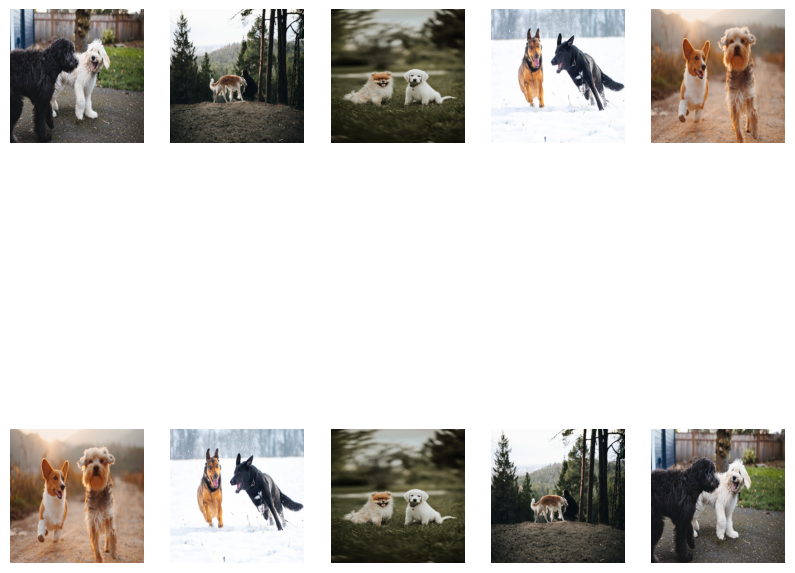

In [95]:
plot_image_grid(f+i, 5)